In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# all of the above was copied from the recent lectures

In [6]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item() # compare if bit-perfect (exactly identical)
  app = torch.allclose(dt, t.grad) # compare if approximately close enough; maybe slight differences to floating point variance
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [7]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # Kaiming Init
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [8]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (n,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [9]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3551, grad_fn=<NegBackward0>)

In [15]:
# dL / dlogprobs 
logprobs.shape
logprobs[range(n), Yb].shape # plug out the probability of each 32 inputs in the batch at the position of the ground truth index Yb

# the loss function L is the negative mean of these probabilites, i.e. mean of 32 values
# let's see how this would translate to a simpler example
# loss = -(a + b + c) / 3
# identical to: loss = -1/3a + -1/3b + -1/3c
# dL / da = -1/3
# or generalized: dL / da = -1/n
# but NOTE: the shape of logprobs is [32, 27]! But we only plug out one value per row (instead of 27) --> what happens to the remaining 26 values?
# Since we calculate our loss by comparing only the prediction for the ground truth index, the remaining 26 values do NOT impact the loss at all
# therefore, intuitively, their gradients will be 0 (since the gradient determines the impact of a value on the loss function)

torch.Size([32])

In [ ]:
#  counts           --*->
#                           probs --log-> logprobs --negative mean->loss
# counts_sum_inv    --*->

In [29]:
counts.shape, counts_sum_inv.shape

# c = a * b, but using tensors
# a[3x3] * c[3x1]
# a11*b1, a12*b1, a13*b1
# a21*b2, a22*b2, a23*b2
# a31*b3, a32*b3, a33*b3
# c[3x3]

(torch.Size([32, 27]), torch.Size([32, 1]))

In [30]:
counts_sum_inv.shape, dprobs.shape

(torch.Size([32, 1]), torch.Size([32, 27]))

In [55]:
counts.shape, dl_by_dprobs.shape

(torch.Size([32, 27]), torch.Size([32, 27]))

In [61]:
counts_sum_inv.shape

torch.Size([32, 1])

In [68]:
counts.shape, counts_sum.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [78]:
logit_maxes.shape

torch.Size([32, 1])

In [90]:
(torch.ones_like(logit_maxes) * dl_by_dnorm_logits).sum(0, keepdim=True)

tensor([[-0.1187, -0.0641,  0.0388, -0.0245,  0.0351, -0.0196,  0.0452,  0.0103,
         -0.0274, -0.0894,  0.0342,  0.0019,  0.0099,  0.0327, -0.0642,  0.0129,
          0.0356,  0.0314, -0.0277,  0.0139,  0.0102,  0.0328,  0.0169,  0.0366,
          0.0378,  0.0018, -0.0027]], grad_fn=<SumBackward1>)

In [96]:
logit_maxes.shape

torch.Size([32, 1])

In [97]:
dl_by_dlogits_maxes.shape

torch.Size([32, 1])

In [99]:
logprobs.shape, dl_by_dlogprobs.shape

(torch.Size([32, 27]), torch.Size([32, 27]))

In [115]:
torch.zeros_like(logits)[:, logits.max(1, keepdim=True).indices] = 1.0

In [129]:
dl_by_dlogits.shape, h.shape, W2.shape, b2.shape

(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27]))

In [142]:
hpreact.shape

torch.Size([32, 64])

In [155]:
dl_by_dhpreact.shape, bngain.shape, bnraw.shape, bnbias.shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]))

In [185]:
# bndiff * bnvar_inv
dl_by_dbnraw.shape, bndiff.shape, bnvar_inv.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [194]:
bnvar.shape

torch.Size([1, 64])

In [204]:
# bndiff2 derivative
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
# What happens here is we basically scale bndiff2 by a scalar (1/(n-1)), which is a vector of shape [32]
# example
# a11 a12
# a21 a22
# ------>
# b1 b2 where
# b1 = (1/(n-1)) * (a11 a21)
# b2 = (1/(n-1)) * (a12 a22)
bndiff2.shape, dl_by_dbnvar.shape
dl_by_dbndiff2 = (1/(n-1)) * torch.ones_like(bndiff2) * dl_by_dbnvar

(torch.Size([32, 64]), torch.Size([1, 64]))

In [213]:
bndiff.shape, hprebn.shape, bnmeani.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [227]:
# hprebn = embcat @ W1 + b1
dl_by_dhprebn.shape, embcat.shape, W1.shape, b1.shape

(torch.Size([32, 64]),
 torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]))

In [230]:
# embcat = emb.view(emb.shape[0], -1)
dl_by_dembcat.shape, emb.shape
dl_by_demb = dl_by_dembcat.view(-1, 3, 10)

torch.Size([32, 30])

In [246]:
# emb = C[Xb]
dl_by_demb.shape, C.shape, Xb.shape
dl_by_dC = torch.zeros_like(C)
for k in range (Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dl_by_dC[ix] += dl_by_demb[k, j]

In [247]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one


# IMPORTANT NOTE: The gradient HAS TO HAVE THE SAME SHAPE as the input value/vector/matrix
dl_by_dl = -1 

dl_by_dlogprobs = torch.zeros_like(logprobs) # we need the exact same shape as logprobs, but fill it with 0
dl_by_dlogprobs[range(n), Yb] = -1/n # set only the relevant values impacting the loss to the derivative as outlined above
assert(dl_by_dlogprobs.shape == logprobs.shape)

dl_by_dprobs = (1 / probs) * dl_by_dlogprobs
assert(dl_by_dprobs.shape == probs.shape)

dl_by_dcounts_sum_inv = (counts * dl_by_dprobs).sum(1, keepdim=True) # sum because we need one gradient per input value
assert(dl_by_dcounts_sum_inv.shape == counts_sum_inv.shape)

dl_by_dcounts = counts_sum_inv * dl_by_dprobs # this is only the first local gradient for counts, as counts goes into multiple steps
assert(dl_by_dcounts.shape == counts.shape)

dl_by_dcounts_sum = -(1 / counts_sum **2) * dl_by_dcounts_sum_inv
assert(dl_by_dcounts_sum.shape == counts_sum.shape)

# counts_sum = counts.sum(1, keepdim=True) ### What is happening here? Let's break it down
# counts is a [32, 27] matrix and we sum up all column values (sum(1) = row-wise sum)
# therefore, we receive a [32, 1] matrix in counts_sum
# this can be generalized as follows
# a11 a12 a13 ---> b1 = (a11 + a12 + a13)
# a21 a22 a21 ---> b2 = (a21 + a22 + a23)
# a31 a32 a33 ---> b3 = (a31 + a32 + a33)
# as we can see, all we do is addition
# and what did we learn about gradients during addition operations? The gradient simply gets passed along / routed to the previous parts
# therefore, the gradient of each matrix value aXY is 1.0 multiplied by the incoming gradient
# what do we need? We need a matrix in the shape of [32, 27] that is all 1.0
# and then multiply these values by the incoming gradient according to the chain rule
dl_by_dcounts += torch.ones_like(counts) * dl_by_dcounts_sum # NOTE: += since gradients need to be aggregated when the value serves as input for multiple operations
assert(dl_by_dcounts.shape == counts.shape)

dl_by_dnorm_logits = norm_logits.exp() * dl_by_dcounts
assert(dl_by_dnorm_logits.shape == norm_logits.shape)

dl_by_dlogit_maxes = -1.0 * (torch.ones_like(logit_maxes) * dl_by_dnorm_logits).sum(1, keepdim=True)
assert(dl_by_dlogit_maxes.shape == logit_maxes.shape)

dl_by_dlogits = torch.ones_like(logits) * dl_by_dnorm_logits
assert(dl_by_dlogits.shape == logits.shape)

# NOTE: This is a special case since we use tha max values for normalization to allow for numeric stability of our logits
# SPECIAL NOTE: You could also do this as a clever one-liner using one-hot:
# dl_by_dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dl_by_dlogit_maxes
tmp = torch.zeros_like(logits) # set all logit gradients to zero
# IMPORTANT: We need to use range(n) instead of : !!!
tmp[range(n), logits.max(1).indices] = 1.0 # only set the logit gradients for the MAX logits, since those are used for normalization
dl_by_dlogits += tmp * dl_by_dlogit_maxes # chain rule
assert(dl_by_dlogits.shape == logits.shape)

# How would we go about differentiating logits = h @ W2 + b2?
# Let's do this with a simplified example
# Assume d = a @b + c where d.shape = [2x2]; a.shape = [2x2]; b.shape = [2x2] and c.shape = [2x1]
# Step 1: Matrix Multiplication
# Step 2: Derivatives dL / da_ij; Simplify etc.
# OR ...
# We can simply make the shapes match: 
# dl_by_dlogits.shape, h.shape, W2.shape, b2.shape
# (torch.Size([32, 27]),
#  torch.Size([32, 64]),
#  torch.Size([64, 27]),
#  torch.Size([27]))
dl_by_dh = dl_by_dlogits @ W2.T
assert(dl_by_dh.shape == h.shape)
dl_by_dW2 = h.T @ dl_by_dlogits
assert(dl_by_dW2.shape == W2.shape)
dl_by_db2 = dl_by_dlogits.sum(0)
assert(dl_by_db2.shape == b2.shape)

dl_by_dhpreact = (1 - h**2) * dl_by_dh
assert(dl_by_dhpreact.shape == hpreact.shape)

dl_by_dbngain = (bnraw * dl_by_dhpreact).sum(0, keepdim=True)
assert(dl_by_dbngain.shape == bngain.shape)
dl_by_dbnraw = dl_by_dhpreact * bngain
assert(dl_by_dbnraw.shape == bnraw.shape)
dl_by_dbnbias = (dl_by_dhpreact * 1.0).sum(0, keepdim=True) # in addition, we simply pass along the gradient; * 1.0 is not necessary
assert(dl_by_dbnbias.shape == bnbias.shape)

dl_by_dbndiff =  bnvar_inv * dl_by_dbnraw
assert(dl_by_dbndiff.shape == bndiff.shape)
dl_by_dbnvar_inv = (bndiff * dl_by_dbnraw).sum(0, keepdim=True)
assert(dl_by_dbnvar_inv.shape == bnvar_inv.shape)

dl_by_dbnvar = (-0.5 * (bnvar + 1e-5)**-1.5) * dl_by_dbnvar_inv # according to Power Rule
assert(dl_by_dbnvar.shape == bnvar.shape)

dl_by_dbndiff2 = (1/(n-1)) * torch.ones_like(bndiff2) * dl_by_dbnvar
assert(dl_by_dbndiff2.shape == bndiff2.shape)

dl_by_dbndiff += (2 * bndiff) * dl_by_dbndiff2 # Power Rule
assert(dl_by_dbndiff.shape == bndiff.shape)

dl_by_dbnmeani = (-1.0 * dl_by_dbndiff).sum(0, keepdim=True)
assert(dl_by_dbnmeani.shape == bnmeani.shape)

dl_by_dhprebn = dl_by_dbndiff.clone()
assert(dl_by_dhprebn.shape == hprebn.shape)

dl_by_dhprebn += 1.0/n * (torch.ones_like(hprebn) * dl_by_dbnmeani)


dl_by_dembcat = dl_by_dhprebn @ W1.T
dl_by_dW1 = embcat.T @ dl_by_dhprebn
dl_by_db1 = dl_by_dhprebn.sum(0)

dl_by_demb = dl_by_dembcat.view(emb.shape)

dl_by_demb.shape, C.shape, Xb.shape
dl_by_dC = torch.zeros_like(C)
for k in range (Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dl_by_dC[ix] += dl_by_demb[k, j]

# CROSS CHECK OUR CALCULATIONS TO PYTORCH AUTOGRAD FOR VALIDATION
cmp('logprobs', dl_by_dlogprobs, logprobs)
cmp('probs', dl_by_dprobs, probs)
cmp('counts_sum_inv', dl_by_dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dl_by_dcounts_sum, counts_sum)
cmp('counts', dl_by_dcounts, counts)
cmp('norm_logits', dl_by_dnorm_logits, norm_logits)
cmp('logit_maxes', dl_by_dlogit_maxes, logit_maxes)
cmp('logits', dl_by_dlogits, logits)
cmp('h', dl_by_dh, h)
cmp('W2', dl_by_dW2, W2)
cmp('b2', dl_by_db2, b2)
cmp('hpreact', dl_by_dhpreact, hpreact)
cmp('bngain', dl_by_dbngain, bngain)
cmp('bnbias', dl_by_dbnbias, bnbias)
cmp('bnraw', dl_by_dbnraw, bnraw)
cmp('bnvar_inv', dl_by_dbnvar_inv, bnvar_inv)
cmp('bnvar', dl_by_dbnvar, bnvar)
cmp('bndiff2', dl_by_dbndiff2, bndiff2)
cmp('bndiff', dl_by_dbndiff, bndiff)
cmp('bnmeani', dl_by_dbnmeani, bnmeani)
cmp('hprebn', dl_by_dhprebn, hprebn)
cmp('embcat', dl_by_dembcat, embcat)
cmp('W1', dl_by_dW1, W1)
cmp('b1', dl_by_db1, b1)
cmp('emb', dl_by_demb, emb)
cmp('C', dl_by_dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [180]:
bnbias.shape

torch.Size([1, 64])

In [181]:
dl_by_dhpreact.shape

torch.Size([32, 64])

In [248]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3551290035247803 diff: -2.384185791015625e-07


In [250]:
dlogits = F.softmax(logits, 1) # calculate the probabilities for each character across all 32 examples in mini batch
dlogits[range(n), Yb] -= 1 # subtract 1.0 from the CORRECT character / ground truth Y
dlogits /= n # scale the gradient down by n to arrive at the mean

cmp("logits", dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 6.28642737865448e-09


In [254]:
F.softmax(logits, 1)[0] # only for the first element/example in our mini batch of 32 elements
# as we can see, the values are almost all equally likely at this state of the network

tensor([0.0703, 0.0848, 0.0186, 0.0502, 0.0211, 0.0810, 0.0250, 0.0363, 0.0176,
        0.0315, 0.0402, 0.0379, 0.0381, 0.0272, 0.0354, 0.0139, 0.0091, 0.0197,
        0.0153, 0.0508, 0.0513, 0.0223, 0.0265, 0.0721, 0.0565, 0.0258, 0.0214],
       grad_fn=<SelectBackward0>)

In [261]:
# to find out where we need to fine-tune our model, we identify the
dlogits[0] * n # pre-scaling, this is exactly equal to the probabilities of the Softmax, except for the position of the correct element, where we subtracted -1

# LET'S CHECK OUT THE MAGIC OF THE CROSS ENTROPY LOSS AND WHAT IT IS DOING IN THE BACKWARD PASS

# Why do we do this?
# Remember, dlogits are the GRADIENTS and GRADIENTS REPRESENT FORCES
# The gradients tell us the direction in which we want to pull or push ("nudge") our values
# And the direction is simple: We want to push UP on the probabilities of the correct values
# And we want to pull DOWN on the probabilities of the incorrect values
# And also remember: These sum up to 0.0. Therefore, if we have a high probability on a misprediction AND we have a low probability on the correct prediction, the remaining probabilities will be near 0. Therefore, we can automatically pull down on the incorrect probability by simultaneously pushing up on the correct probability.
# Think of this as a pulley-system ("Kabelzug") --> When you pull down on on end, the other end will be pushed up and vice versa.
# So by pulling down on one logit, we will push up other logits.
# Therefore, the more we pull in the direction of the correct probability, the less force we will apply to the remaining incorrect logits.
# This is happening in each row
# and the amount of push and pull is exactly equalized since the sum of each row is 0.0
# The more wrong a prediction, the larger will be the force pulling in the opposite direction. (i.e. the amount to which you mispredict is proportionate to the strength of the pull)

# Important fact:
# If the predictions came out perfectly correct, we would have 0 probabilities on all but one position, and this position would be the correct one.
# Therefore, F.softmax(logits, 1) would look something like [0, 0, 0, 1, 0, 0]
# If we now subtract 1.0 from the correct prediction, we would end up with all 0.0s in dlogits [0, 0, 0, 0, 0, 0]--> Therefore, we will NOT apply ANY force, since the prediction is already correct
# Counter Example: Let's say that our model is 100% predicting the wrong value.
# We would arrive at something akin to F.softmax(logits, 1) = [1, 0, 0, 0, 0, 0]
# and our dlogits would be [1, 0, 0, -1, 0, 0] <-- REMEMBER: THEY SUM TO 0.0 !!!
# What would happen now? In order arrive at the perfect state of all 0s in dlogits, we would heavily pull down on the first index (since the UPDATE step is -learning_rate * gradient) and we would heavily push up on the correct index (-learning_rate * -gradient). Therefore, our neural net will adjust itself by nudging its values in the direction of the gradient.
# After one nudge, what will happen?
# The probabilities will be updated. F.softmax(logits, 1) after the next iteration might result in [0.8, 0, 0, 0.2, 0, 0]. By subtracting -1 from the correct index to arrive at dlogits = [0.8, 0, 0, -0.8, 0, 0], we will once again pull down on the incorrect prediction and push up on the correct.
# After the next iteration, we might end up at F.softmax(logits, 1) = [0.4, 0, 0, 0.6, 0, 0]; dlogits = [0.4, 0, 0, -0.4, 0, 0] and so on until we arrive at a correct prediction, where we will no longer update the gradients since their forces will be all 0s.

# Why is this even more amazing?
# Due to the backward pass or backpropagation, these gradients are distributed and interconnected throughout the network. Therefore, each push and pull has effects across the entire network, fine-tuning and nudging each parameter in order to arrive at the correct solution as indicated by the ground truth

tensor(-1.2666e-07, grad_fn=<SumBackward0>)

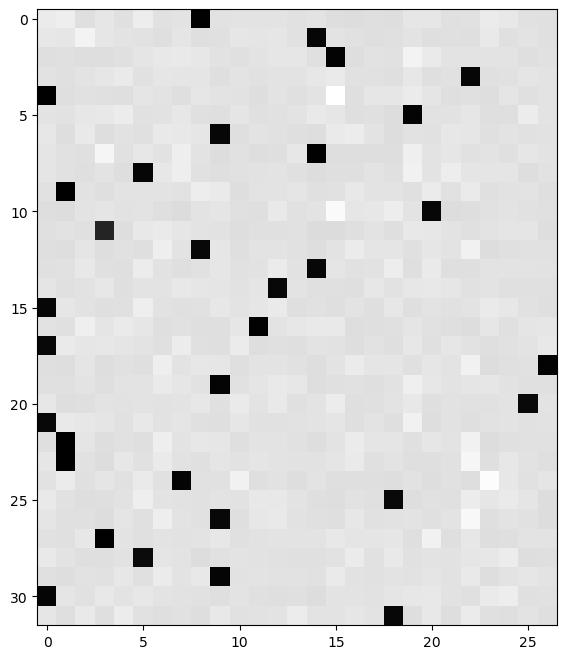

In [251]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap="gray")